# ClearMap parameter sweep

New users *must* use this notebook to find the optimal parameters for cell detection on their images before processing any data through the pipeline. Follow the instructions below.

#### Warning #1: 
Check to make sure elastix is installed under `/usr/bin/elastix` on your local computer, as the `Settings.py` checks the Elastix paths before any imports. You can validate this by typing `which elastix` into the terminal to make sure the path is indeed `/usr/bin/elastix`.

#### Warning #2:
You will need a relatively powerful desktop to run many iterations (20+) of parameters succesfully. We suggest at least 20-50 GB of RAM to allow for data manipulations. If planning to run on a laptop using the cluster, see the `run_parameter_sweep.py` and `sub_parameter_sweep.sh` scripts (**note**: need some basic knowledge of bash scripting and HPC clusters for these).

## Part 1: Setup

#### Run the following imports:

In [1]:
import os, sys, shutil, pickle, tifffile, numpy as np
from itertools import product
from skimage.exposure import rescale_intensity

from ClearMap.cluster.preprocessing import updateparams, listdirfull, arrayjob, makedir, removedir
from ClearMap.cluster.directorydeterminer import directorydeterminer
from ClearMap.cluster.par_tools import celldetection_operations
from ClearMap.cluster.utils import load_kwargs

Elastix sucessfully initialized from path: /usr


Set the home directory of your computer to the variable `systemdirectory` so appropriate file paths can be set in the rest of the dictionary.

In [2]:
systemdirectory = "/home/wanglab"

#### Set paths to data
The `inputdictionary` structure is as follows:

* Key = Path to data 
* Value = `list["xx", "##"]` where xx = regch, injch, or cellch and ## = two digit channel number

The two digit channel number is based on the order of channels imaged in the LaVision acquisition setup. This will typically be alphanumerically ordered. For example, if you acquired a multi-channel stack using the 488 and 647 nm laser, `488 = 00`, and `647 = 01`. 

The naming of the channels is categoried as follows:

* "regch" = channel to be used for registration, assumption is all other channels are signal
* "cellch" = channel(s) to apply cell detection
* "injch" = channels(s) to quantify injection site

If you have acquired multiple channels in different imaging sessions of the same sample, and thus have multiple folders, you can set them in the `inputdictionary` as such:
`inputdictionary={path_1: [["regch", "00"]], path_2: [["cellch", "00"], ["injch", "01"]]}`

In [3]:
inputdictionary={
os.path.join(systemdirectory, "LightSheetTransfer/Jess/202001_tpham_crus1_ymaze_cfos/200123_tpcrus1_lat_cfos_an13_1_3x_488_008na_1hfds_z10um_100msec_12-23-02"): [["regch", "00"]],
os.path.join(systemdirectory, "LightSheetTransfer/Jess/202001_tpham_crus1_ymaze_cfos/200123_tpcrus1_lat_cfos_an13_1_3x_647_008na_1hfds_z10um_250msec_12-11-38"): [["cellch", "00"]]
}

#### Filling the parameter dictionary

The parameter dictionary is used in the rest of the software to refer back to inputs and outputs, as well as imaging and processing attributes. The keys in the `params` dictionary represent:

* `inputdirectory` = the input dictionary we previously made. You can set the value to this `inputdictionary` variable.
* `outputdirectory` = where you want to save your parameter sweep results. Typically in the experiment's folder, based on the sample name.
* `xyz_scale` = the pixel size of your images. For the LaVision UltraMicroscope, this is typically: 1.3xobjective w/ 1xzoom = 5um/pixel; 4x objective = 1.63um/pixel
* `tiling_overlap` = percent overlap taken during tiling. Can set to "0" if no tiling was done.
* `blendtype` = process by which you want to blend the 2 lightsheets, typically "sigmoidal" is best.
* `intensitycorrection` = calculate mean intensity of overlap between tiles shift higher of two towards lower; typically set to "False"
* `rawdata` = set to "True" if raw data of both lightsheets were individually acquired (**recommended**)
* `slurmjobfactor` = number of planes to process per job/per iteration, typically set to 50 to accomodate for memory limitations (**note**: only applied if not tiling)


In [4]:
params={
"inputdictionary": inputdictionary, #don"t need to touch
"outputdirectory": os.path.join(systemdirectory, "Desktop/zahra/tpcrus1_lat_cfos_an13"),
"xyz_scale": (5.0, 5.0, 10.0), #micron/pixel; 1.3xobjective w/ 1xzoom 5um/pixel; 4x objective = 1.63um/pixel
"tiling_overlap": 0.00, #percent overlap taken during tiling
"blendtype" : "sigmoidal", #False/None, "linear", or "sigmoidal" blending between tiles, usually sigmoidal; False or None for images where blending would be detrimental;
"intensitycorrection" : False, #True = calculate mean intensity of overlap between tiles shift higher of two towards lower - useful for images where relative intensity is not important (i.e. tracing=True, cFOS=False)
"rawdata" : True, # set to true if raw data is taken from scope and images need to be flattened; functionality for rawdata =False has not been tested**
"slurmjobfactor": 50, #number of array iterations per arrayjob since max job array on SPOCK is 1000
}

#### Define function to sweep parameters

The `sweep_parameters` function will save final outputs in `outputdirectory/parameter_sweep`. It's inputs are:

* `jobid` = the iteration number based on the parameter ranges you are testing. This is usually the counter of the variable `tick` set below.
* ClearMap parameters:
    * `rBP_size_r` = background subtraction via morphological opening. This is the most important pre-treatment step, usually always turned on. The parameter size is a tuple with (x,y) in pixels and correspond to an ellipsoid of this size.
    * `fEMP_hmax_r` = findExtendedMaximaParameter. Extended Maxima, another filter to use for objects that contain several peaks of intensity, like for instance a higher resolution view of a cell nucleus where you might have a more granular texture. Our c-fos nuclear signal is typically imaged at low resolution, so the object only appears as a single peak, so we typically set the `hMax` parameter to "None".
    * `fEMP_size_r` = size in pixels (x,y) for the structure element of the morphological opening. Typically set to 0 if `hMax` is not performed.
    * `fEMP_threshold_r` = Typically set to "None" if `hMax` is not performed.
    * `fIP_method_r` = findIntensityParameter. ClearMap will look for the center of the 3D shape painted by the Extended Maxima and attribute the x,y,z to this coordinate. This is the coordinate that will be saved in the point file. However, we noticed that often, the pixel that contains the highest intensity (the peak) is not always the center of the volume. This is likely due to potential deformations of the shape of the nucleus by the objective lens. If the parameter method is set to "None", then the peak intensity will be also the pixel at the center of the volume. We’ll set the parameter to "Max" to look if there is a voxel around the center that has a higher intensity than the center. 
    * `fIP_size_r` = Maxima detection using the findIntensityParameter (fIP) done by looking around the center with a box of this pixel size (e.g. (5,5,5)), which indicates by how many pixels in each direction from the center the code will be looking for a peak of higher intensity.
    * `dCSP_threshold_r` = detectCellShapeParameter. The cell shape is not used for the cell detection itself (which is just searching for local maxima in intensity), but measuring the cell volume will be important to later remove the local peaks detected that do not correspond to an actual cell. The shape detection is done by a watershed, which will paint the volume of the cell from the detected center outwards. The threshold corresponds to the background intensity, and tells the watershed detection where to stop painting. This value is based on the background subtracted image here. If the threshold is set to None, then the cell shape detection is bypassed.
* `optimization_chunk` = the chunk of tissue you would like to test cell detection parameters, where 0,1,2,4,... corresponds to Z0000-Z0050, Z0050-Z0100, etc. Typically set to 4-6 to test middle of the brain.
* `cleanup` = If "True", deletes individual "background", "cell", etc. folders in the optimization folder and just saves 3 panel image of raw image, background subtracted image, and non-thresholded cells detected in `outputdirectory/parameter_sweep`.
* `kwargs` = `params` dictionary set above.


See [Renier et al. (2016)](https://www.sciencedirect.com/science/article/pii/S0092867416305554?via%3Dihub) for more details on ClearMap parameters.


In [5]:
def sweep_parameters(jobid, rBP_size_r, fEMP_hmax_r, fEMP_size_r, fEMP_threshold_r,
                                     fIP_method_r, fIP_size_r, dCSP_threshold_r, 
                                     tick, optimization_chunk = 4, cleanup =True, **kwargs):
    
    #make folder for final output:
    opt = kwargs["outputdirectory"]; makedir(opt)
    out = opt+"/parameter_sweep"; makedir(out)
    out0 = opt+"/parameter_sweep_jobid_{}".format(str(jobid).zfill(4)); makedir(out0)

    rBP_size, fEMP_hmax, fEMP_size, fEMP_threshold, fIP_method, fIP_size, dCSP_threshold = [(rBP_size, 
                    fEMP_hmax, fEMP_size, fEMP_threshold, fIP_method, fIP_size, dCSP_threshold) for rBP_size, 
                    fEMP_hmax, fEMP_size, fEMP_threshold, fIP_method, fIP_size, 
                    dCSP_threshold in product(rBP_size_r, fEMP_hmax_r, fEMP_size_r, 
                    fEMP_threshold_r, fIP_method_r, fIP_size_r, dCSP_threshold_r)][jobid]

    pth = out0+"/rBP_size{}_fEMP_hmax{}_fEMP_size{}_fEMP_threshold{}_fIP_method{}_fIP_size{}_dCSP_threshold{}.tif".format(rBP_size, fEMP_hmax, fEMP_size, fEMP_threshold, fIP_method, fIP_size, dCSP_threshold)

    if not os.path.exists(pth):

        try:

            #set params for sweep
            kwargs["removeBackgroundParameter_size"] = (rBP_size, rBP_size) #Remove the background with morphological opening (optimised for spherical objects), e.g. (7,7)
            kwargs["findExtendedMaximaParameter_hmax"] = fEMP_hmax # (float or None)     h parameter (for instance 20) for the initial h-Max transform, if None, do not perform a h-max transform
            kwargs["findExtendedMaximaParameter_size"] = fEMP_size # size in pixels (x,y) for the structure element of the morphological opening
            kwargs["findExtendedMaximaParameter_threshold"] = fEMP_threshold # (float or None)     include only maxima larger than a threshold, if None keep all local maxima
            kwargs["findIntensityParameter_method"] =  fIP_method # (str, func, None)   method to use to determine intensity (e.g. "Max" or "Mean") if None take intensities at the given pixels
            kwargs["findIntensityParameter_size"] = (fIP_size,fIP_size,fIP_size) # (tuple)             size of the search box on which to perform the *method*
            kwargs["detectCellShapeParameter_threshold"] = dCSP_threshold # (float or None)      threshold to determine mask. Pixels below this are background if None no mask is generated

            #tmp
            nkwargs = load_kwargs(kwargs["outputdirectory"])
            kwargs["outputdirectory"] = out0
            nkwargs.update(kwargs)
            pckloc=out0+"/param_dict.p"; pckfl=open(pckloc, "wb"); pickle.dump(nkwargs, pckfl); pckfl.close()

            #run cell detection
            sys.stdout.write("\n\n\n           *****Iteration {} of {}*****\n\n\n".format(jobid, tick))
            sys.stdout.write("    Iteration parameters: {}     {}     {}     {}     {}     {}     {}".format(kwargs["removeBackgroundParameter_size"], kwargs["findExtendedMaximaParameter_hmax"], kwargs["findExtendedMaximaParameter_size"], kwargs["findExtendedMaximaParameter_threshold"],         kwargs["findIntensityParameter_method"],         kwargs["findIntensityParameter_size"],        kwargs["detectCellShapeParameter_threshold"]))
            celldetection_operations(optimization_chunk, testing = True, **kwargs)

            #list, load, and maxip
            raw = [xx for xx in listdirfull(out0+"/optimization/raw") if "~" not in xx and ".db" not in xx]
            raw.sort(); 
            raw_im = np.squeeze(tifffile.imread(raw))
            raw_mx = np.max(raw_im, axis = 0)
            bkg = [xx for xx in listdirfull(out0+"/optimization/background") if "~" not in xx and "Thumbs.db" not in xx]; bkg.sort()
            bkg_im = tifffile.imread(bkg)
            bkg_mx = np.max(bkg_im, axis = 0)
            cell = [xx for xx in listdirfull(out0+"/optimization/cell") if "~" not in xx and ".db" not in xx]
            cell.sort()
            cell_im = tifffile.imread(cell) 
            cell_mx = np.max(cell_im, axis = 0)

            #concatenate and save out:
            bigim = np.concatenate((raw_mx, bkg_mx, cell_mx), axis = 1); del bkg, bkg_im, bkg_mx, cell, cell_im,cell_mx
            if cleanup: removedir(out0)
            if not cleanup: tifffile.imsave(pth, bigim.astype("uint16"), compress = 1)
            
            #save in main
            npth = out+"/jobid_{}_rBP_size{}_fEMP_hmax{}_fEMP_size{}_fEMP_threshold{}_fIP_method{}_fIP_size{}_dCSP_threshold{}.tif".format(str(jobid).zfill(4), rBP_size, fEMP_hmax, fEMP_size, fEMP_threshold, fIP_method, fIP_size, dCSP_threshold)
            tifffile.imsave(npth, bigim.astype("uint16"), compress = 1)
            

        except Exception as e:
            print("Error on: {}\n\nerror={}".format(pth,e))
            im = np.zeros((10,10,10))
            tifffile.imsave(pth, im, compress = 1)
            with open(os.path.join(out, "errored_files.txt"), "a") as fl:
                fl.write("\n\n{}\n{}\n".format(pth, kwargs))
                fl.close
        
        return


## Part 2: Process Images

#### Run "step 1" to blend dual lightsheet images and set up parameter dictionary.

These functions are mostly from T. Pisano's [BrainPipe](https://github.com/PrincetonUniversity/BrainPipe) pipeline. See its repository and README for more info.

The range for the variable `iid` depends on how many z-planes you have collected for your brain volumes. You can typically approximate the range by calculating $$\frac{no. \; of \; z-planes}{slurmjobfactor}$$

**Note**: This is a time consuming/data-heavy step. You only need to process images once, and can then run a variety of parameter sweeps on those same images.

In [ ]:
makedir(params["outputdirectory"])

###make parameter dictionary and pickle file:
updateparams(os.getcwd(), **params) # e.g. single job assuming directory_determiner function has been properly set
#copy folder into output for records
if not os.path.exists(os.path.join(params["outputdirectory"], "ClearMapCluster")): shutil.copytree(os.getcwd(), os.path.join(params["outputdirectory"], "clearmap_cluster"), ignore=shutil.ignore_patterns("^.git")) #copy run folder into output to save run info

#run step 1 to populate fullsizedata folder
for iid in range(0, 20):
    arrayjob(iid, cores=5, compression=1, **params)

## Part 3: Iterate through parameters

### Modify parameter ranges to run the `sweep_parameters` function on a subset of your data

You can then iterate through all possible combinations of the parameters.

In [6]:
rBP_size_r = [5] ###evens seem to not be good  
fEMP_hmax_r = [None]
fEMP_size_r = [0] 
fEMP_threshold_r = [None] 
fIP_method_r = ["Max"] #["Max, "Mean"]
fIP_size_r = [3,5,10]
dCSP_threshold_r = [250]

# calculate number of iterations
tick = 0
for rBP_size, fEMP_hmax, fEMP_size, fEMP_threshold, fIP_method, fIP_size, dCSP_threshold in product(rBP_size_r, 
                          fEMP_hmax_r, fEMP_size_r, fEMP_threshold_r, fIP_method_r, fIP_size_r, dCSP_threshold_r):
    tick +=1

print("\n\nNumber of iterations is {}:".format(tick))



Number of iterations is 3:

Set the variable `cleanup` to "True" or "False" depending on if you want to closely inspect the cell detection plane-by-plane in the "optimization" folder in the individual parameter combinations.

In [8]:
cleanup = False

Then, iterate through the combination of parameters.

In [7]:
for jobid in range(tick):
    try:
        sweep_parameters(jobid, rBP_size_r, fEMP_hmax_r, fEMP_size_r, fEMP_threshold_r,
                                     fIP_method_r, fIP_size_r, dCSP_threshold_r, tick, cleanup = cleanup, **params)
    except Exception as e:
        print("Jobid {}, Error given {}".format(jobid, e))




           *****Iteration 0 of 3*****


    Iteration parameters: (5, 5)     None     0     None     Max     (3, 3, 3)     250
This function is set for optimization of cell detection, optimization results in:
   /home/wanglab/Desktop/zahra/tpcrus1_lat_cfos_an13/parameter_sweep_jobid_0000/optimization

ProcessMethod = cluster
Process 4: Illumination correction: flatfield : None
Process 4: Illumination correction: background: None
Process 4: Illumination correction: scaling   : None
Process 4: Illumination correction: save      : /home/wanglab/Desktop/zahra/tpcrus1_lat_cfos_an13/parameter_sweep_jobid_0000/optimization/illumination_correction
Process 4: 
{'stackId': 4, 'nStacks': 16, 'source': '/home/wanglab/Desktop/zahra/tpcrus1_lat_cfos_an13/full_sizedatafld/tpcrus1_lat_cfos_an13_1_3x_647_008na_1hfds_z10um_250msec_ch00/tpcrus1_lat_cfos_an13_1_3x_647_008na_1hfds_z10um_250msec_C00_Z\\d{4}.tif', 'x': <built-in function all>, 'y': <built-in function all>, 'z': (178, 238), 'zCenters': (18

Process ForkPoolWorker-1:
Traceback (most recent call last):
  File "/home/wanglab/anaconda3/envs/lightsheet/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/wanglab/anaconda3/envs/lightsheet/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/wanglab/anaconda3/envs/lightsheet/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/home/wanglab/anaconda3/envs/lightsheet/lib/python3.7/multiprocessing/pool.py", line 47, in starmapstar
    return list(itertools.starmap(args[0], args[1]))
  File "/home/wanglab/wang/zahra/python/ClearMapCluster/ClearMap/ImageProcessing/StackProcessing.py", line 83, in _processSubStack
    seg = sf(img, subStack = sub, out = pw, **pp);
  File "/home/wanglab/wang/zahra/python/ClearMapCluster/ClearMap/ImageProcessing/SpotDetection.py", line 131, in detectSpots
    imgshape = detectCellShape(img2

KeyboardInterrupt: 

## Part 4: Evaluating results

If you have set `cleanup` to "True", the results of the parameter sweep will be populated in the folder called "parameter_sweep" in the main output directory. Each TIF file in this folder consist of combination of parameters that were iterated through. The image (which you can view in ImageJ/Fiji) consists of 3 panels:

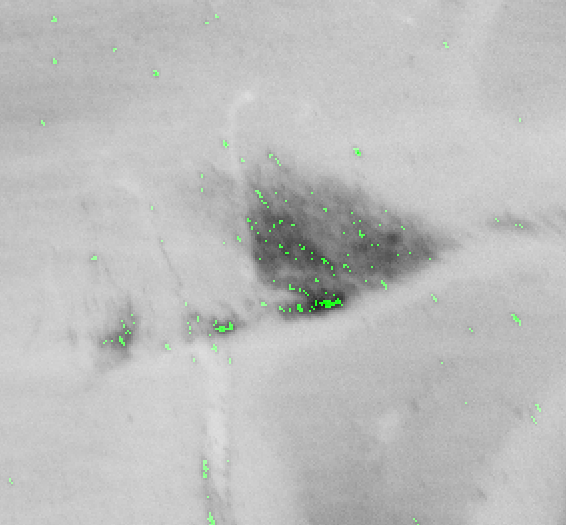

From left to right, the panels represent the raw image (1), the image after background subtraction (2), and the image after cell detection (3). These cells can be further thresholded by intensity in the main pipeline (see step 6 of the main pipeline). Note that this image represents a max projection of the ~50 planes on which the cell detection parameters are tested.

Typically, you can identify a set of parameters that work well with your data by looking at these panels. For further, more detailed inquiry, you can alternatively set the `cleanup` parameter to "False", and examine individual planes of your images after background subtraction and cell detection in the "optimization" folder corresponding to the `jobid` variable. e.g. `outputdirectory/parameter_sweep_jobid_0002/optimization/cell`.

The best way is to actually overlay raw data on the "cell" files to examine how well the parameters are able to detect cells in the images. The set of parameters that work "best" will highly depend what you are looking for in a cell detector (e.g. high precision vs. high recall). 

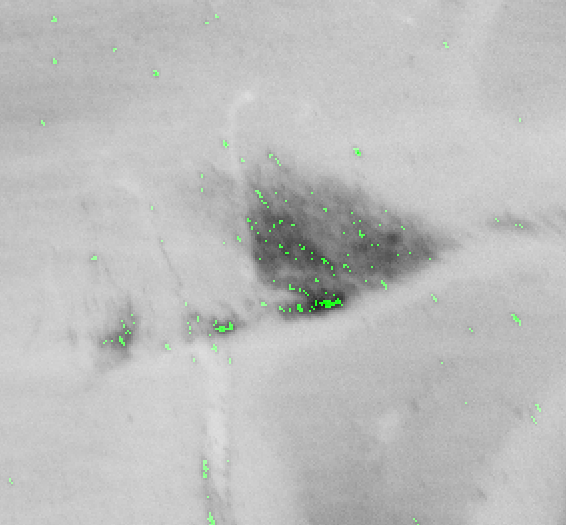
(Image showing raw data in grays with cells detected by ClearMap in green)